# HCA Model Criticism

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scvi
from scvi.criticism import PosteriorPredictiveCheck as PPC
from ppc_plot_utils import PPCPlot
import scanpy as sc
import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

scvi.settings.seed = 1

# plotting commands for the styling
# sns.reset_orig()
mplscience.set_style(reset_current=True, name="default")

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/cupy/_environment.py:487: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed 

In [4]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
plt.style.fonttype = None
mpl.rc('pdf', fonttype=42)

In [5]:
local_dir = "/external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility"
temp_fig_dir = "../figures"

## 1️⃣ Get the data and train models

Following [this](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/api_overview.html) tutorial, we will use the HCA dataset.

The dataset used is a subset of the heart cell atlas dataset:
Litviňuková, M., Talavera-López, C., Maatz, H., Reichart, D., Worth, C. L., Lindberg, E. L., … & Teichmann, S. A. (2020). Cells of the adult human heart. Nature, 588(7838), 466-472.

Let's train the model as usual. Also save the model and data on disk as we'll need them later.

In [5]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=local_dir)
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

INFO     File /external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/hca_subsampled_20k.h5ad already      
         downloaded                                                                                                


### Train the model.

In [5]:
good_model_path = f"{local_dir}/good_model"

In [11]:
adata2 = adata.copy()

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model = scvi.model.SCVI(adata)
model.train()

model.save(good_model_path, save_anndata=True, overwrite=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [04:34<00:00,  1.46it/s, v_num=1, train_loss_step=326, train_loss_epoch=284]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:34<00:00,  1.45it/s, v_num=1, train_loss_step=326, train_loss_epoch=284]


### Train a bad model -- not enough epochs.

In [8]:
bad_model_1_path = f"{local_dir}/bad_model_1"

In [12]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model_bad_1 = scvi.model.SCVI(adata)
model_bad_1.train(max_epochs=5)

model_bad_1.save(bad_model_1_path, save_anndata=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/5: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s, v_num=1, train_loss_step=269, train_loss_epoch=296]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s, v_num=1, train_loss_step=269, train_loss_epoch=296]


### Train a bad model -- too small of a latent space.

In [13]:
bad_model_2_path = f"{local_dir}/bad_model_2"

In [14]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model_bad_2 = scvi.model.SCVI(adata, n_latent=2)
model_bad_2.train()

model_bad_2.save(bad_model_2_path, save_anndata=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 400/400: 100%|██████████| 400/400 [04:34<00:00,  1.46it/s, v_num=1, train_loss_step=396, train_loss_epoch=288]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:34<00:00,  1.46it/s, v_num=1, train_loss_step=396, train_loss_epoch=288]


### Train a bad model overfit

In [22]:
overfit_model_path = f"{local_dir}/overfit_model"

In [24]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)
model = scvi.model.SCVI(adata, n_latent=100, n_layers=3, n_hidden=1024)
model.train(max_epochs=5000, check_val_every_n_epoch=1)

model.save(overfit_model_path, save_anndata=True, overwrite=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5000/5000: 100%|██████████| 5000/5000 [1:16:52<00:00,  1.07it/s, v_num=1, train_loss_step=345, train_loss_epoch=211] 

`Trainer.fit` stopped: `max_epochs=5000` reached.


Epoch 5000/5000: 100%|██████████| 5000/5000 [1:16:52<00:00,  1.08it/s, v_num=1, train_loss_step=345, train_loss_epoch=211]


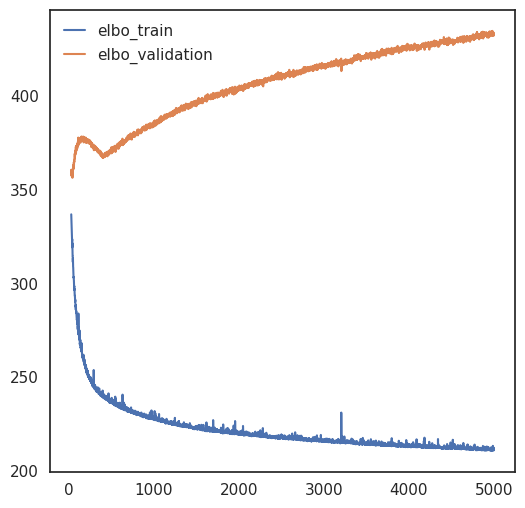

In [25]:
plt.plot(model.history['elbo_train'][30:], label='elbo_train')
plt.plot(model.history['elbo_validation'][30:], label='elbo_validation')
plt.legend()
plt.savefig(f"{temp_fig_dir}/overfit_model_losses.png")
plt.show()

## 2️⃣ Evaluate

In [6]:
good_model_path = f"{local_dir}/good_model"
bad_model_1_path = f"{local_dir}/bad_model_1"
bad_model_2_path = f"{local_dir}/bad_model_2"
overfit_model_path = f"{local_dir}/overfit_model"

### Evaluate the good model

In [15]:
model = scvi.model.SCVI.load(good_model_path, accelerator="cpu")

INFO     File /external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/good_model/model.pt already          
         downloaded                                                                                                


In [9]:
# run ppc+cv
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, count_layer_key="counts", n_samples=2)
ppc.coefficient_of_variation("features")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d", model=model)

fig_path = f'{temp_fig_dir}/hca_good_model_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

NameError: name 'model' is not defined

model=SCVI | metric=cv_cell | n_cells=18641:
Mean Absolute Error=1.00 Validation 1.05,
Pearson correlation=0.72 Validation 0.69,
Spearman correlation=0.76 Validation 0.72,
R^2=0.22 Validation 0.09,



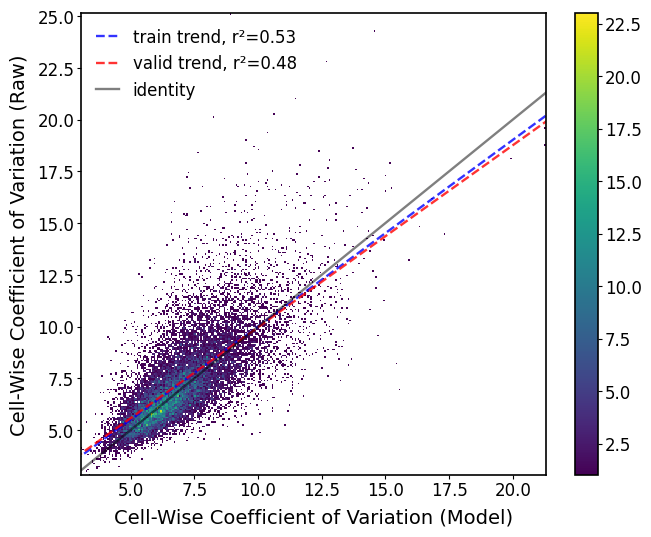

In [26]:
ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d", model=model)

fig_path = f'{temp_fig_dir}/hca_good_model_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

model=SCVI | metric=cv_gene | n_cells=18641:
Mean Absolute Error=1.62,
Pearson correlation=0.92,
Spearman correlation=0.99,
R^2=0.84,



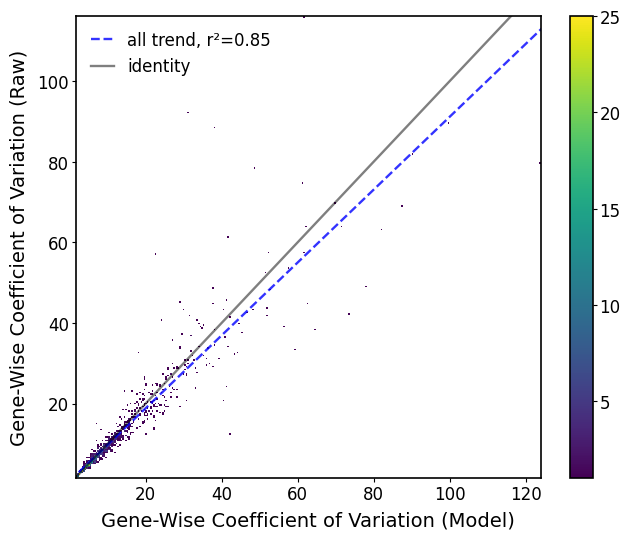

In [30]:
ppc.coefficient_of_variation("cells")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=False, plt_type="hist2d", model=model)

fig_path = f'{temp_fig_dir}/hca_good_model_ppc_cv_gene.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

/external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/ppc_plot_utils.py:243: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.violinplot(model_de_metrics, palette=sns.color_palette("pastel"))


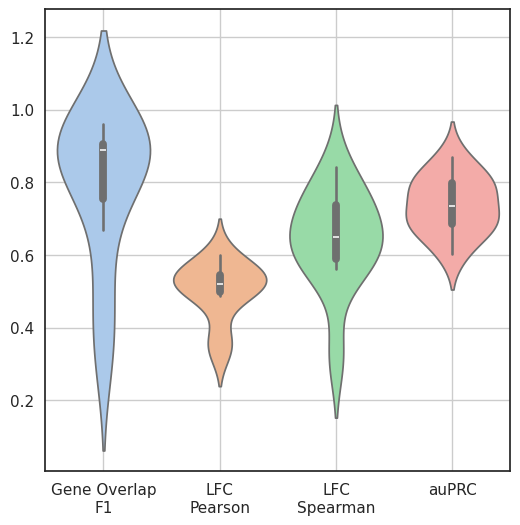

In [10]:
# run ppc+DE
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, n_samples=2)
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2, indices=model.validation_indices)

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_violin",
)
fig_path = f'{temp_fig_dir}/good_model_de_summary_barplot_validation.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

/external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/ppc_plot_utils.py:243: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.violinplot(model_de_metrics, palette=sns.color_palette("pastel"))


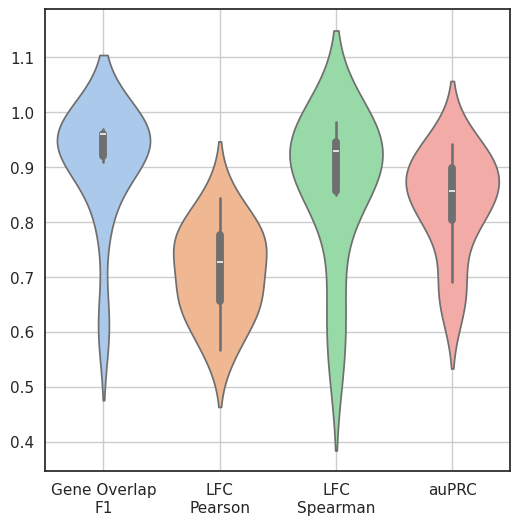

In [11]:
# run ppc+DE
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, n_samples=2)
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2)

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_violin",
)
fig_path = f'{temp_fig_dir}/good_model_de_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

### Evaluate the bad model 1

In [31]:
model = scvi.model.SCVI.load(bad_model_1_path)

INFO     File /external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/bad_model_1/model.pt already         
         downloaded                                                                                                


model=SCVI | metric=cv_cell | n_cells=18641:
Mean Absolute Error=1.39 Validation 1.40,
Pearson correlation=0.45 Validation 0.42,
Spearman correlation=0.53 Validation 0.50,
R^2=-0.37 Validation -0.44,



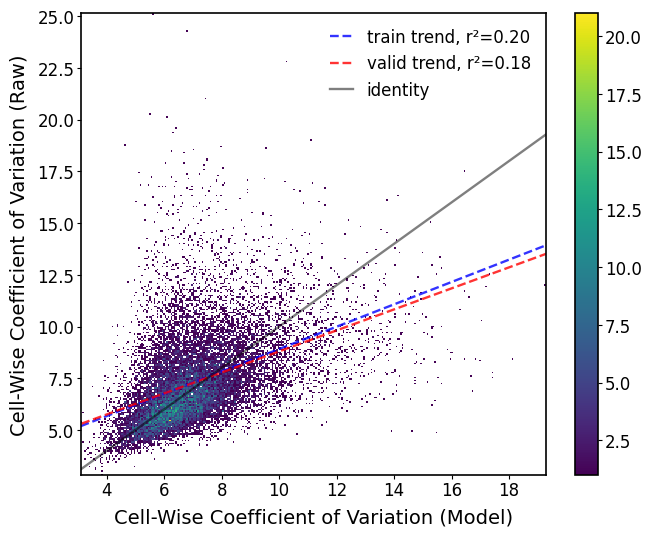

In [32]:
# run ppc+cv for bad model 1
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, count_layer_key="counts", n_samples=2)
ppc.coefficient_of_variation("features")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d", model=model)

fig_path = f'{temp_fig_dir}/hca_bad_model_1_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

model=SCVI | metric=cv_gene | n_cells=18641:
Mean Absolute Error=2.46,
Pearson correlation=0.87,
Spearman correlation=0.95,
R^2=0.26,



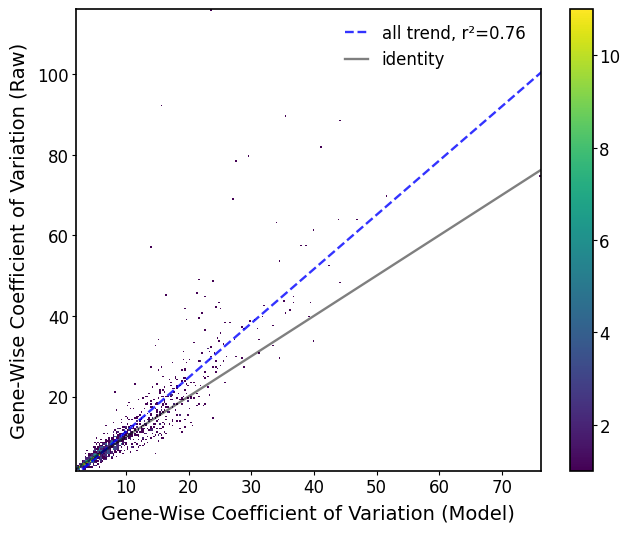

In [33]:
ppc.coefficient_of_variation("cells")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=False, plt_type="hist2d", model=model)

fig_path = f'{temp_fig_dir}/hca_bad_model_1_ppc_cv_gene.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

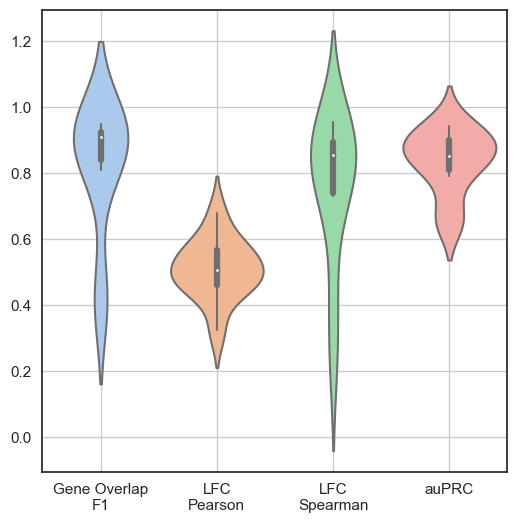

In [35]:
# run ppc+DE for bad model 1
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, n_samples=2)
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2)

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_violin",
)
fig_path = f'{temp_fig_dir}/hca_bad_model_1_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

### Evaluate the bad model 2

In [34]:
model = scvi.model.SCVI.load(bad_model_2_path)

INFO     File /external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/bad_model_2/model.pt already         
         downloaded                                                                                                


model=SCVI | metric=cv_cell | n_cells=18641:
Mean Absolute Error=1.09 Validation 1.11,
Pearson correlation=0.66 Validation 0.65,
Spearman correlation=0.73 Validation 0.73,
R^2=0.15 Validation 0.15,



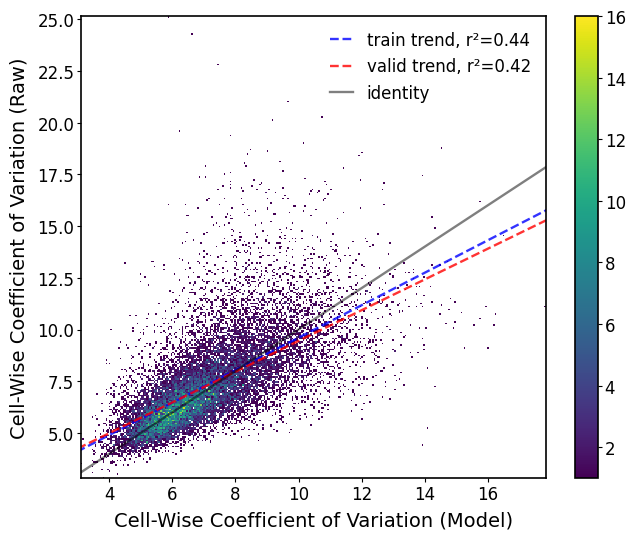

In [35]:
# run ppc+cv for bad model 2
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, count_layer_key="counts", n_samples=2)
ppc.coefficient_of_variation("features")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d", model=model)

fig_path = f'{temp_fig_dir}/hca_bad_model_2_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

model=SCVI | metric=cv_gene | n_cells=18641:
Mean Absolute Error=1.75,
Pearson correlation=0.89,
Spearman correlation=0.98,
R^2=0.71,



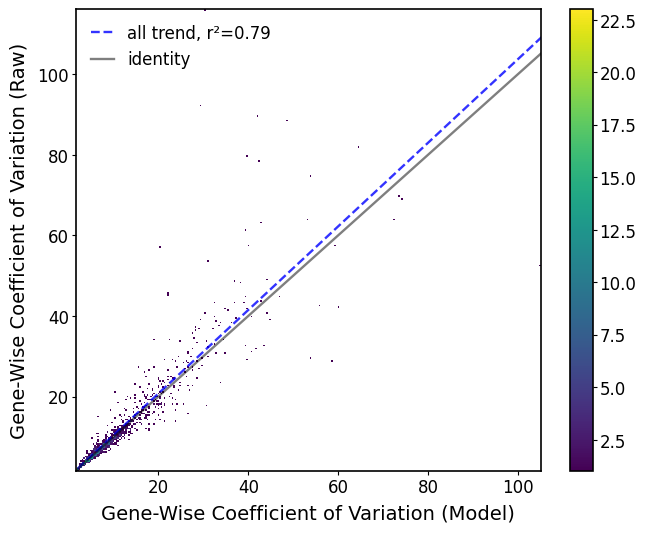

In [36]:
ppc.coefficient_of_variation("cells")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=False, plt_type="hist2d", model=model)

fig_path = f'{temp_fig_dir}/hca_bad_model_2_ppc_cv_gene.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

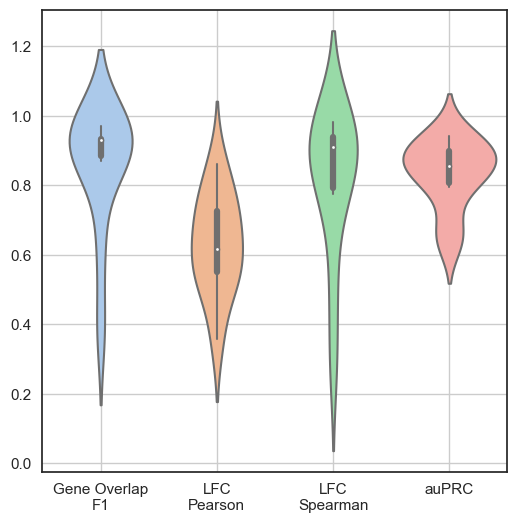

In [27]:
# run ppc+DE for bad model 2
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, n_samples=2)
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2)

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_violin",
)
fig_path = f'{temp_fig_dir}/bad_model_2_de_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

### Evaluate the overfit model

In [7]:
model = scvi.model.SCVI.load(overfit_model_path)

INFO     File /external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/overfit_model/model.pt already       
         downloaded                                                                                                


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


model=SCVI | metric=cv_cell | n_cells=18641:
Mean Absolute Error=1.00 Validation 1.17,
Pearson correlation=0.73 Validation 0.58,
Spearman correlation=0.72 Validation 0.61,
R^2=0.24 Validation -0.38,



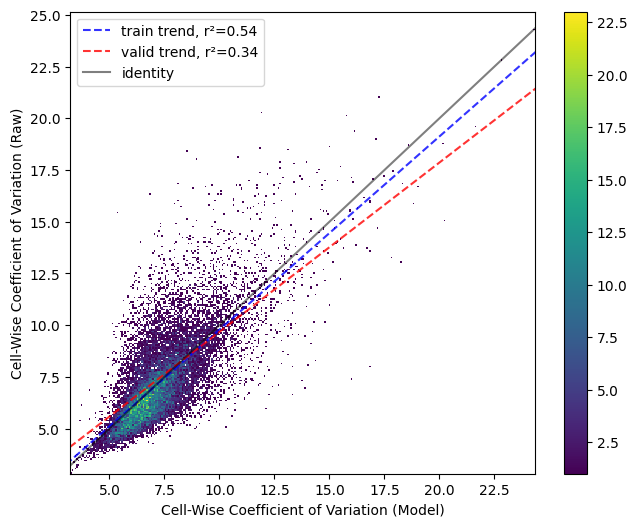

In [10]:
# run ppc+cv for bad model 2
models_dict = {"SCVI": model}
ppc = PPC(adata, models_dict, count_layer_key="counts", n_samples=2)
ppc.coefficient_of_variation("features")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=True, plt_type="hist2d", model=model)

fig_path = f'{temp_fig_dir}/hca_bad_model_overfit_ppc_cv_cell.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

model=SCVI | metric=cv_gene | n_cells=18641:
Mean Absolute Error=2.15,
Pearson correlation=0.98,
Spearman correlation=0.99,
R^2=0.93,



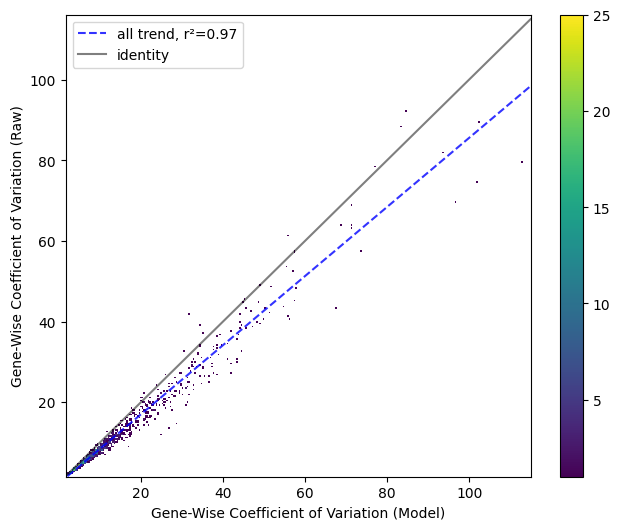

In [11]:
ppc.coefficient_of_variation("cells")

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_cv(model_name="SCVI", cell_wise=False, plt_type="hist2d", model=model)

fig_path = f'{temp_fig_dir}/hca_bad_model_overfit_ppc_cv_gene.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")

/external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/ppc_plot_utils.py:180: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.violinplot(model_de_metrics, palette=sns.color_palette("pastel"))


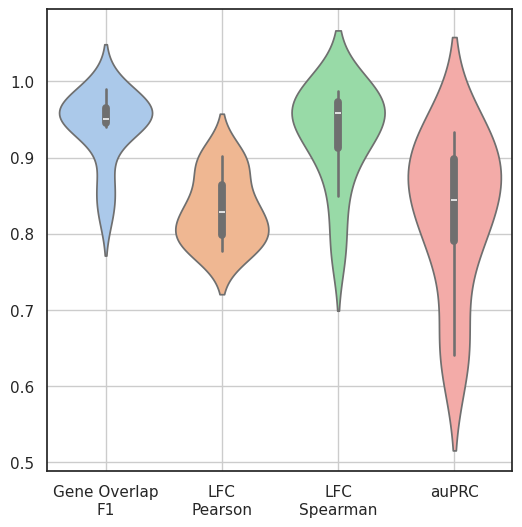

In [59]:
# run ppc+DE for bad model 1
models_dict = {"SCVI": train_model}
ppc = PPC(train_model.adata, models_dict, n_samples=2)
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2)

ppc_plt = PPCPlot(ppc)
ppc_plt.plot_diff_exp(
    "SCVI",
    plot_kind="summary_violin",
)
fig_path = f'{temp_fig_dir}/hca_overfit_model_ppc_cv_cell_train.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

## 3️⃣ Visualize box plots

In [19]:
bad_model_1

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [13]:
good_model = scvi.model.SCVI.load(f"{local_dir}/good_model")
bad_model_1 = scvi.model.SCVI.load(f"{local_dir}/bad_model_1")
bad_model_2 = scvi.model.SCVI.load(f"{local_dir}/bad_model_2")
bad_model_overfit = scvi.model.SCVI.load(f"{local_dir}/overfit_model")

INFO     File /external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/good_model/model.pt already          
         downloaded                                                                                                
INFO     File /external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/bad_model_1/model.pt already         
         downloaded                                                                                                
INFO     File /external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/bad_model_2/model.pt already         
         downloaded                                                                                                
INFO     File /external_data/other/scvi-hub/scvi-hub/scvi-hub-reproducibility/overfit_model/model.pt already       
         downloaded                                                                                                


In [14]:
models_dict = {
    "good_model": good_model,
    "bad_model_1": bad_model_1,
    "bad_model_2": bad_model_2,
    "bad_model_overfit": bad_model_overfit,
}
ppc = PPC(adata, models_dict, n_samples=2, count_layer_key="counts") # All models have the same train indices
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2, indices=good_model.train_indices)

/tmp/ipykernel_2250669/1608760909.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  b = sns.boxplot(


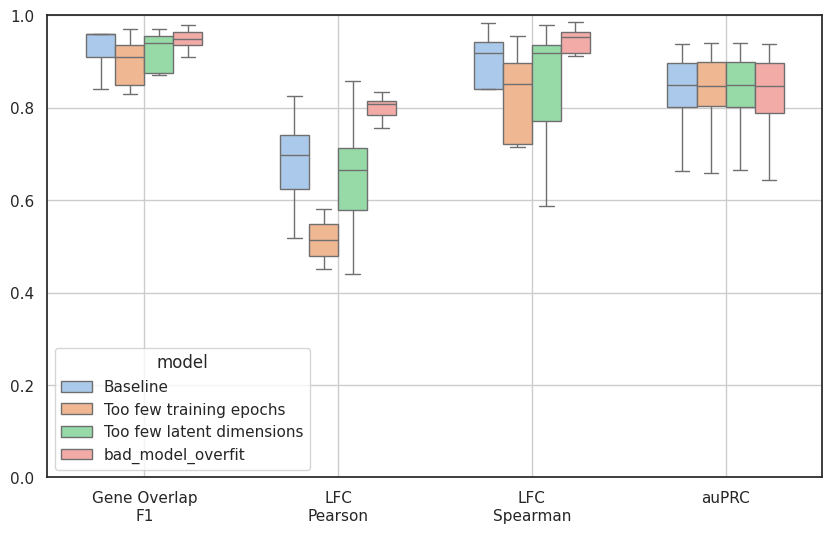

In [15]:
de_metrics = ppc.metrics["diff_exp"]["summary"]
if "lfc_mae" in de_metrics.columns:
    del de_metrics["lfc_mae"]  # not on the same scale as the other ones
if "roc_auc" in de_metrics.columns:
    del de_metrics["roc_auc"]  # skip this for now, TODO fix/remove

# inspired by https://stackoverflow.com/a/68268937
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_theme(style="white")
de_metrics = de_metrics.melt(id_vars=['model'], value_vars=['gene_overlap_f1', 'lfc_pearson', 'lfc_spearman', 'pr_auc'], var_name='Metric', value_name='Value')
metric_names = {
    "gene_overlap_f1": "Gene Overlap\nF1",
    "lfc_pearson": "LFC\nPearson",
    "lfc_spearman": "LFC\nSpearman",
    "pr_auc": "auPRC",
}
model_names = {
    "good_model": "Baseline",
    "bad_model_1": "Too few training epochs",
    "bad_model_2": "Too few latent dimensions",
}
for k,v in metric_names.items():
    de_metrics["Metric"] = de_metrics["Metric"].str.replace(k, v)
for k,v in model_names.items():
    de_metrics["model"] = de_metrics["model"].str.replace(k, v)
b = sns.boxplot(
    data=de_metrics,
    x='Metric',
    y='Value',
    hue='model',
    showfliers = False,
    width=.6,
    palette=sns.color_palette("pastel"),
)
b.set(xlabel=None, ylabel=None)
plt.grid()
plt.ylim(0, 1)

fig_path = f'{temp_fig_dir}/model_comparison_summary_barplot.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [16]:
import numpy as np

np.all(good_model.validation_indices == bad_model_overfit.validation_indices)

True

In [17]:
models_dict = {
    "good_model": good_model,
    "bad_model_1": bad_model_1,
    "bad_model_2": bad_model_2,
    "bad_model_overfit": bad_model_overfit,
}
ppc = PPC(adata, models_dict, n_samples=2, count_layer_key="counts") # All models have the same train indices
ppc.differential_expression(de_groupby="cell_type", p_val_thresh=0.2, indices=good_model.validation_indices)

/tmp/ipykernel_2250669/1702658313.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  b = sns.boxplot(


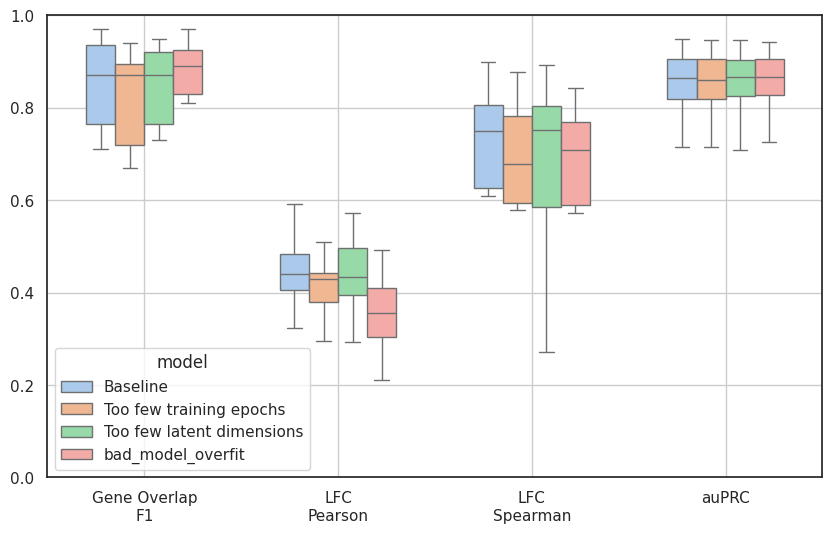

In [18]:
de_metrics = ppc.metrics["diff_exp"]["summary"]
if "lfc_mae" in de_metrics.columns:
    del de_metrics["lfc_mae"]  # not on the same scale as the other ones
if "roc_auc" in de_metrics.columns:
    del de_metrics["roc_auc"]  # skip this for now, TODO fix/remove

# inspired by https://stackoverflow.com/a/68268937
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_theme(style="white")
de_metrics = de_metrics.melt(id_vars=['model'], value_vars=['gene_overlap_f1', 'lfc_pearson', 'lfc_spearman', 'pr_auc'], var_name='Metric', value_name='Value')
metric_names = {
    "gene_overlap_f1": "Gene Overlap\nF1",
    "lfc_pearson": "LFC\nPearson",
    "lfc_spearman": "LFC\nSpearman",
    "pr_auc": "auPRC",
}
model_names = {
    "good_model": "Baseline",
    "bad_model_1": "Too few training epochs",
    "bad_model_2": "Too few latent dimensions",
}
for k,v in metric_names.items():
    de_metrics["Metric"] = de_metrics["Metric"].str.replace(k, v)
for k,v in model_names.items():
    de_metrics["model"] = de_metrics["model"].str.replace(k, v)
b = sns.boxplot(
    data=de_metrics,
    x='Metric',
    y='Value',
    hue='model',
    showfliers = False,
    width=.6,
    palette=sns.color_palette("pastel"),
)
b.set(xlabel=None, ylabel=None)
plt.grid()
plt.ylim(0, 1)

fig_path = f'{temp_fig_dir}/model_comparison_summary_barplot_validation.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


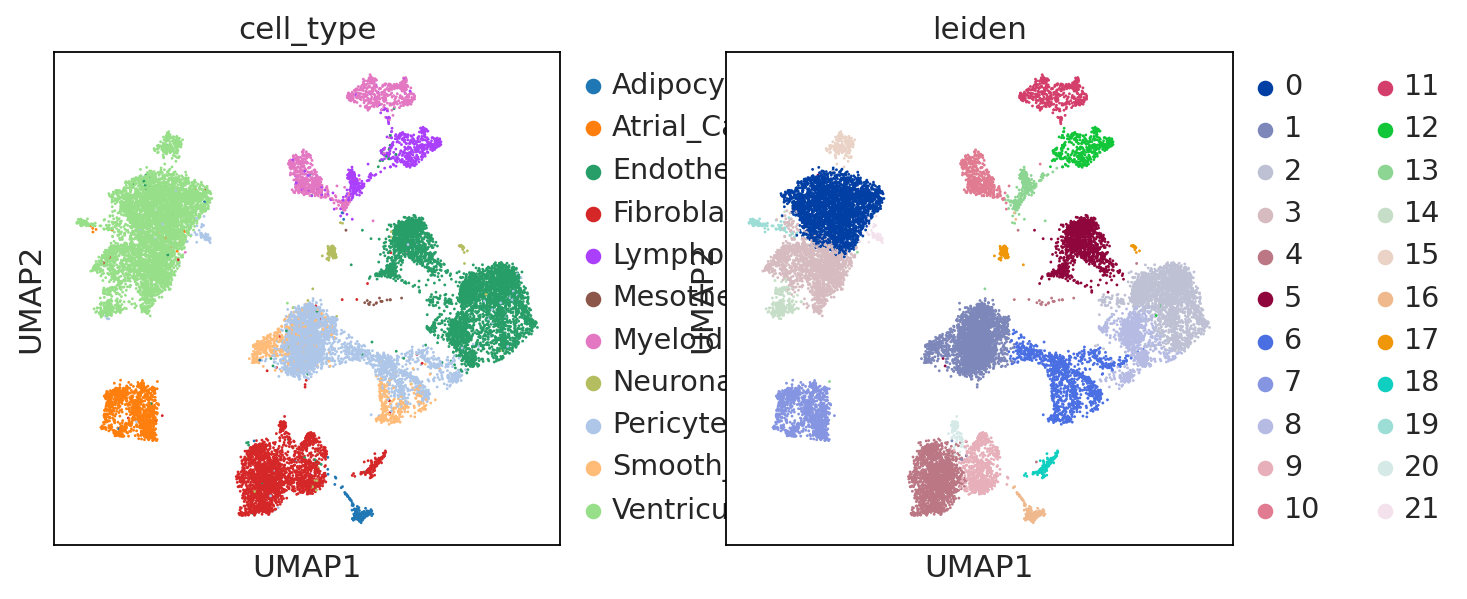

In [26]:
#sc.tl.leiden(adata, resolution=0.8)
sc.set_figure_params(vector_friendly=True, dpi_save=300, fontsize=14)
sc.pl.umap(adata, color=["cell_type", 'leiden'], save="hca_cell_type_umap2.svg")

In [24]:
models_dict = {
    "good_model": good_model,
    "bad_model_1": bad_model_1,
    "bad_model_2": bad_model_2,
    "bad_model_overfit": bad_model_overfit,
}
ppc = PPC(adata, models_dict, n_samples=2, count_layer_key="counts") # All models have the same train indices
ppc.differential_expression(de_groupby="leiden", p_val_thresh=0.2, indices=good_model.validation_indices)

/tmp/ipykernel_2250669/3270859533.py:26: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  b = sns.boxplot(


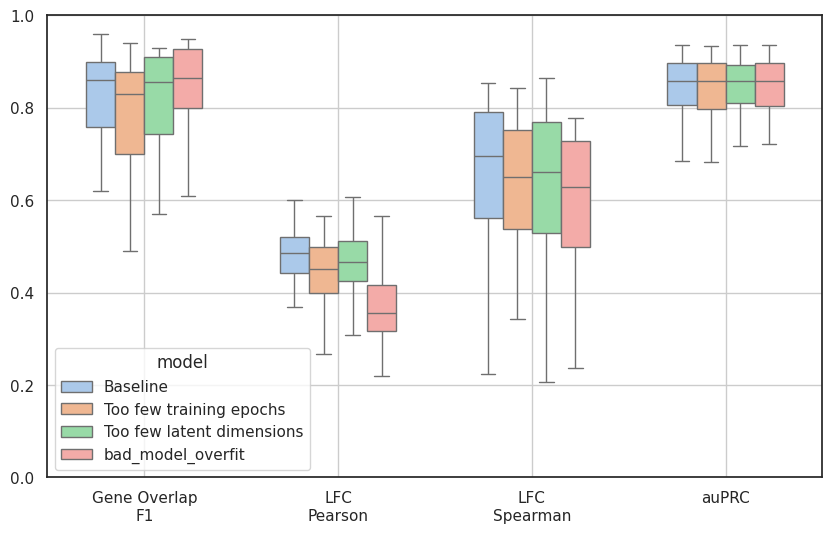

In [25]:
de_metrics = ppc.metrics["diff_exp"]["summary"]
if "lfc_mae" in de_metrics.columns:
    del de_metrics["lfc_mae"]  # not on the same scale as the other ones
if "roc_auc" in de_metrics.columns:
    del de_metrics["roc_auc"]  # skip this for now, TODO fix/remove

# inspired by https://stackoverflow.com/a/68268937
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_theme(style="white")
de_metrics = de_metrics.melt(id_vars=['model'], value_vars=['gene_overlap_f1', 'lfc_pearson', 'lfc_spearman', 'pr_auc'], var_name='Metric', value_name='Value')
metric_names = {
    "gene_overlap_f1": "Gene Overlap\nF1",
    "lfc_pearson": "LFC\nPearson",
    "lfc_spearman": "LFC\nSpearman",
    "pr_auc": "auPRC",
}
model_names = {
    "good_model": "Baseline",
    "bad_model_1": "Too few training epochs",
    "bad_model_2": "Too few latent dimensions",
}
for k,v in metric_names.items():
    de_metrics["Metric"] = de_metrics["Metric"].str.replace(k, v)
for k,v in model_names.items():
    de_metrics["model"] = de_metrics["model"].str.replace(k, v)
b = sns.boxplot(
    data=de_metrics,
    x='Metric',
    y='Value',
    hue='model',
    showfliers = False,
    width=.6,
    palette=sns.color_palette("pastel"),
)
b.set(xlabel=None, ylabel=None)
plt.grid()
plt.ylim(0, 1)

fig_path = f'{temp_fig_dir}/model_comparison_summary_barplot_validation_leiden.svg'
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

## 4️⃣ Benchmark using model for wrong tissue

In [6]:
from scvi.data import cellxgene

local_dir = "/home/cane/Documents/yoseflab/can/scvi-hub"
adata_url = "https://cellxgene.cziscience.com/e/97a17473-e2b1-4f31-a544-44a60773e2dd.cxg/"
query_data = cellxgene(adata_url, filename="ts_epithelial.h5ad", save_path=local_dir, census_version="2023-12-15")

In [7]:
query_data.X = query_data.raw[:, query_data.var_names].X.toarray()

In [8]:
import scvi
from scvi.criticism import PosteriorPredictiveCheck as PPC

In [9]:
# add dataset information:
query_data.obs['dataset'] = query_data.obs['tissue']

In [10]:
scvi.model.SCANVI.prepare_query_anndata(query_data, local_dir)
query_data.obs["scanvi_label"] = "unlabeled"

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               
INFO     Found 99.8% reference vars in query data.                                                                 


/home/cane/miniconda3/envs/hub_paper/lib/python3.10/site-packages/anndata/_core/merge.py:1337: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


## Build a query model

Use `prepare_query_anndata` to re-order the genes and pad any missing genes with 0s, so that query_adata matches exactly the reference in terms of its gene set.  

In [11]:
query_model = scvi.model.SCANVI.load_query_data(query_data, local_dir, accelerator = "cpu")

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/model.pt already downloaded                               


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [12]:
query_model.adata

AnnData object with n_obs × n_vars = 104148 × 2000
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'dataset', 'scanvi_label', '_scvi_batch', '_scvi_labels'
    var: 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    obsp: 'connectivities', 'distances'

In [35]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [36]:
query_model.train(
    max_epochs=surgery_epochs,
    accelerator="gpu",
    **train_kwargs_surgery,
)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 256/500:  51%|█████     | 256/500 [32:12<30:42,  7.55s/it, v_num=1, train_loss_step=920, train_loss_epoch=1.3e+3]     
Monitored metric elbo_train did not improve in the last 10 records. Best score: 1333.855. Signaling Trainer to stop.


In [37]:
query_save_path = f"{local_dir}/query_model_ts_epithelial"
query_model.save(query_save_path, overwrite=True)

In [13]:
query_save_path = f"{local_dir}/query_model_ts_epithelial"
query_model = scvi.model.SCANVI.load(query_save_path, adata=query_data)

INFO     File /home/cane/Documents/yoseflab/can/scvi-hub/query_model_ts_epithelial/model.pt already downloaded     


In [14]:
query_data.obsm['X_scanvi_emb'] = query_model.get_latent_representation()

In [15]:
import scvi.criticism as criticism
from ppc_plot_utils import PPCPlot

In [16]:
temp_fig_dir = "../figures_query/"

In [19]:
import numpy as np

In [ ]:
ppc = PPC(query_model.adata, {"SCANVI": query_model}, n_samples=2)
ppc.coefficient_of_variation("features")
ppc_plt = PPCPlot(ppc)

In [53]:
import os

os.mkdir(temp_fig_dir)

liver
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=3.28 Validation 3.34,
Pearson correlation=0.56 Validation 0.52,
Spearman correlation=0.60 Validation 0.52,
R^2=0.29 Validation 0.23,



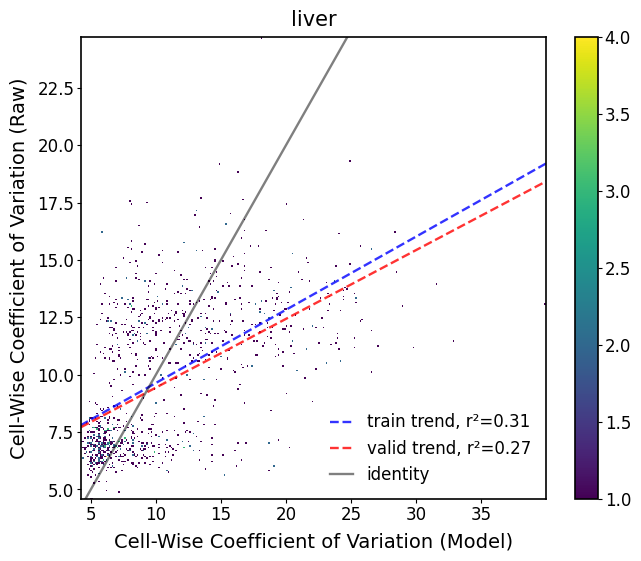

trachea
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=1.52 Validation 1.45,
Pearson correlation=0.69 Validation 0.72,
Spearman correlation=0.70 Validation 0.71,
R^2=0.31 Validation 0.28,



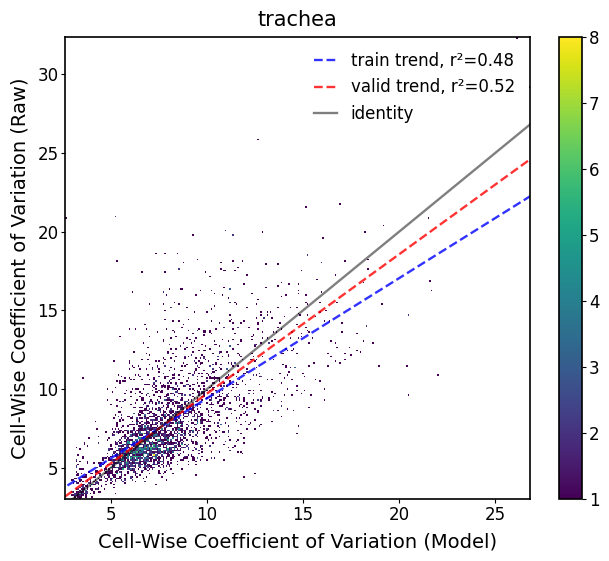

parotid gland
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=4.91 Validation 4.89,
Pearson correlation=0.16 Validation 0.21,
Spearman correlation=0.09 Validation 0.14,
R^2=-0.11 Validation -0.08,



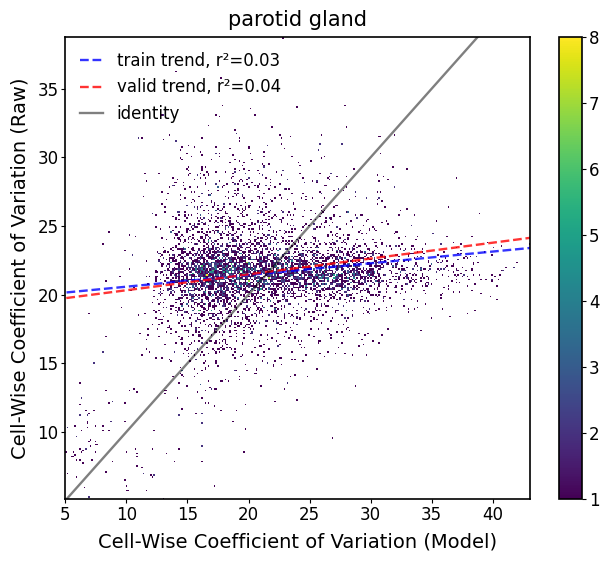

anterior part of tongue
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=3.36 Validation 3.41,
Pearson correlation=0.14 Validation 0.00,
Spearman correlation=0.16 Validation 0.07,
R^2=-0.47 Validation -0.72,



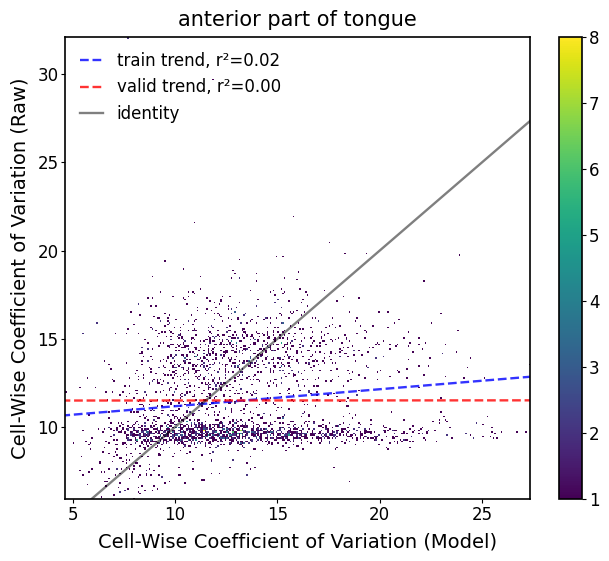

posterior part of tongue
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=2.37 Validation 2.47,
Pearson correlation=0.59 Validation 0.59,
Spearman correlation=0.62 Validation 0.62,
R^2=0.25 Validation 0.27,



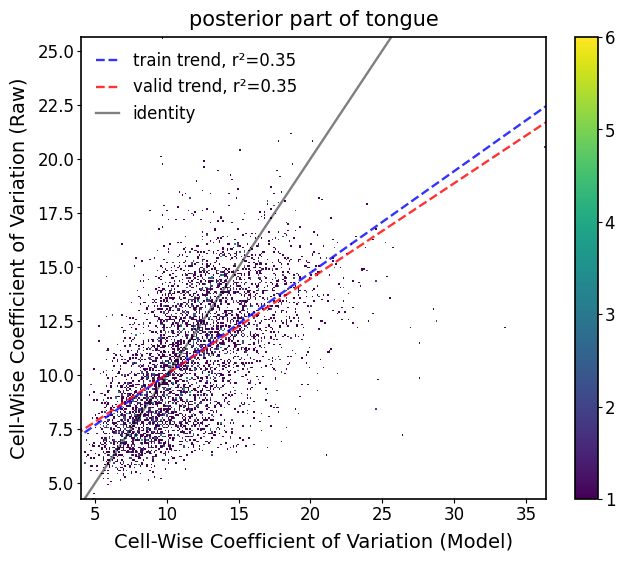

mammary gland
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=3.32 Validation 3.21,
Pearson correlation=0.30 Validation 0.29,
Spearman correlation=0.36 Validation 0.32,
R^2=-4.78 Validation -4.96,



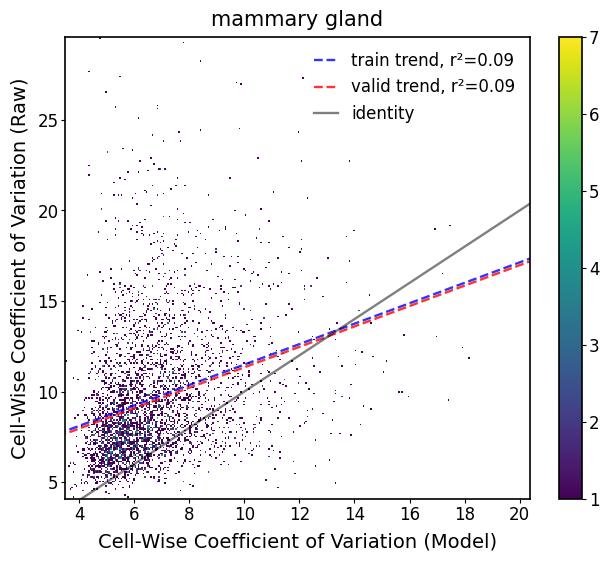

skipping endometrium
skipping myometrium
eye
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=2.55 Validation 2.91,
Pearson correlation=0.21 Validation 0.11,
Spearman correlation=0.19 Validation 0.04,
R^2=-0.42 Validation -0.72,



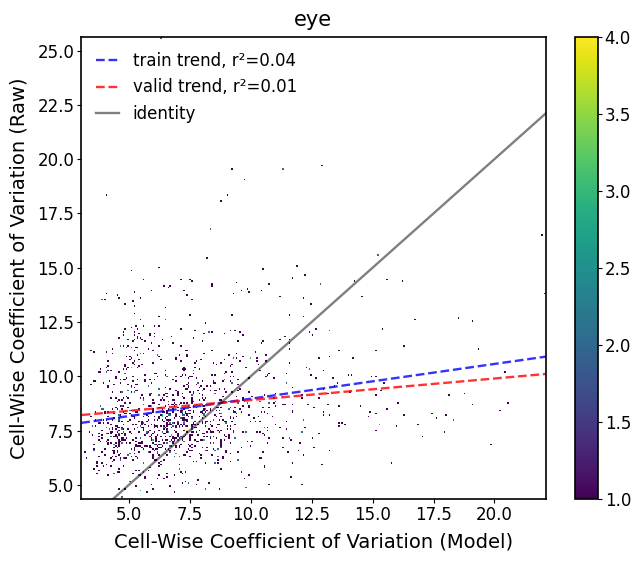

conjunctiva
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=0.76 Validation 0.82,
Pearson correlation=0.23 Validation 0.34,
Spearman correlation=0.22 Validation 0.35,
R^2=-0.71 Validation -0.63,



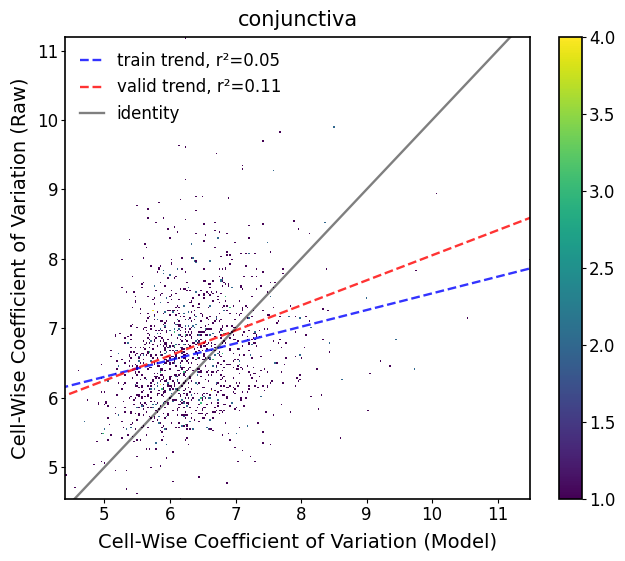

skipping skin of body
skipping cardiac atrium
skipping cardiac ventricle
exocrine pancreas
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=7.81 Validation 7.85,
Pearson correlation=0.46 Validation 0.48,
Spearman correlation=0.56 Validation 0.60,
R^2=-4.35 Validation -4.95,



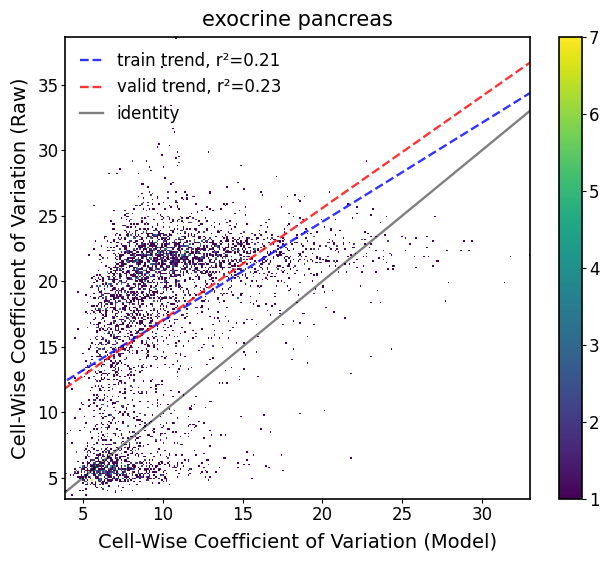

prostate gland
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=3.65 Validation 3.77,
Pearson correlation=0.29 Validation 0.30,
Spearman correlation=0.29 Validation 0.30,
R^2=-13.35 Validation -12.71,



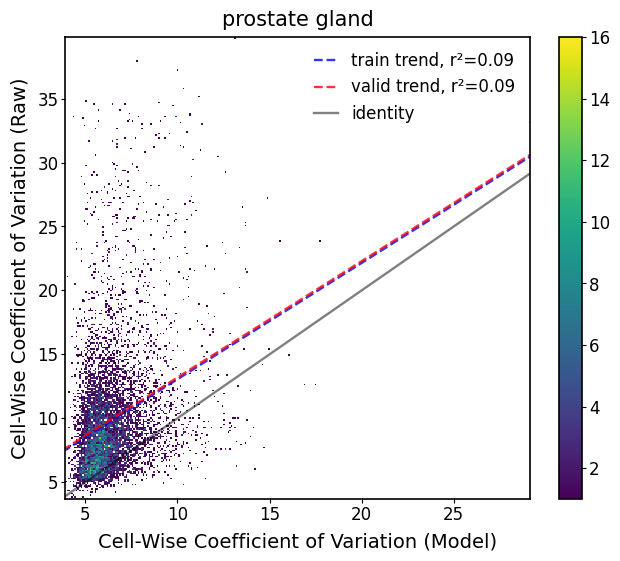

skipping skin of abdomen
skipping skin of chest
skipping lacrimal gland
skipping uterus
skipping tongue
sublingual gland
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=2.26 Validation 2.30,
Pearson correlation=0.49 Validation 0.45,
Spearman correlation=0.63 Validation 0.58,
R^2=0.08 Validation 0.05,



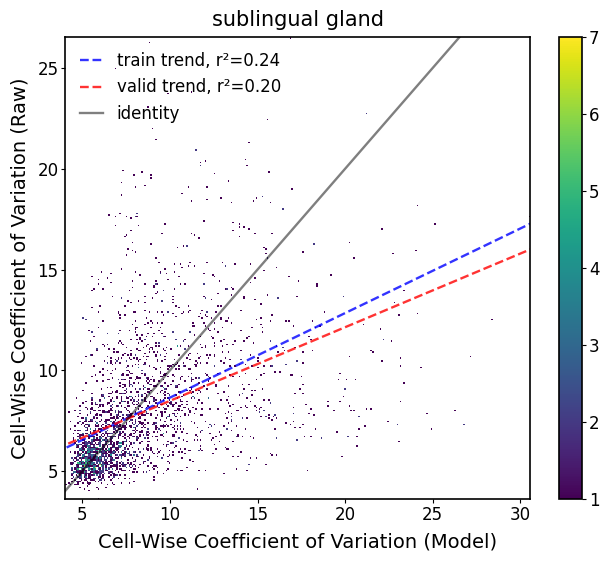

skipping thymus
cornea
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=2.14 Validation 2.33,
Pearson correlation=0.07 Validation 0.01,
Spearman correlation=0.07 Validation 0.05,
R^2=-1.59 Validation -2.00,



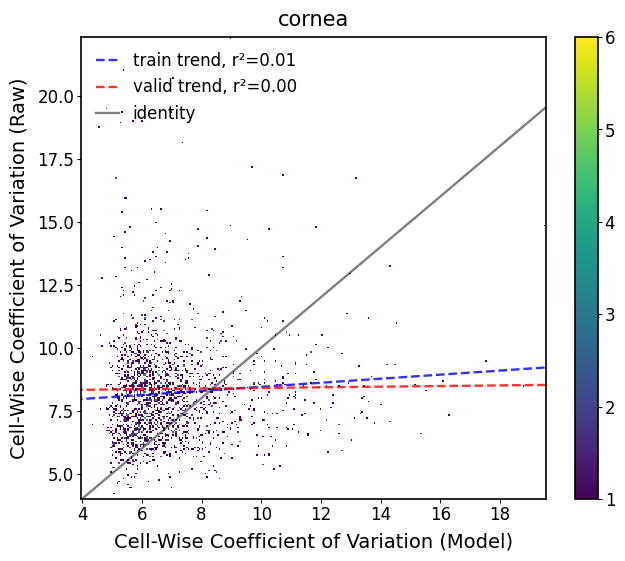

skipping retinal neural layer
skipping sclera
bladder organ
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=1.54 Validation 1.58,
Pearson correlation=0.13 Validation 0.07,
Spearman correlation=0.20 Validation 0.12,
R^2=-2.08 Validation -3.38,



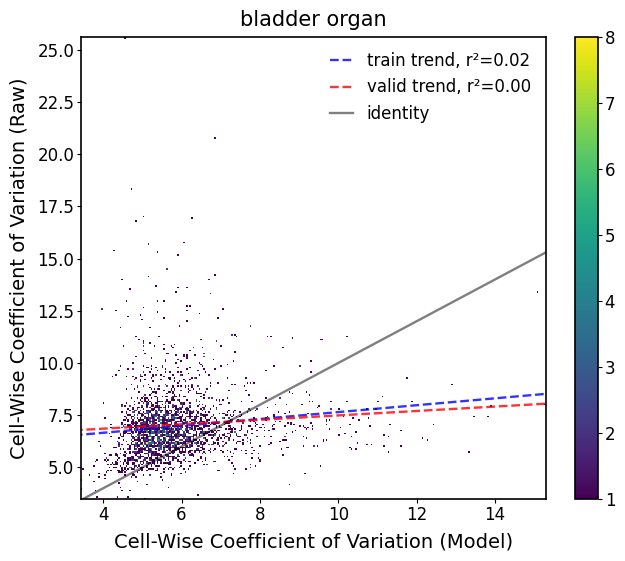

large intestine
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=2.10 Validation 2.21,
Pearson correlation=-0.06 Validation -0.02,
Spearman correlation=0.01 Validation 0.00,
R^2=-9.70 Validation -10.57,



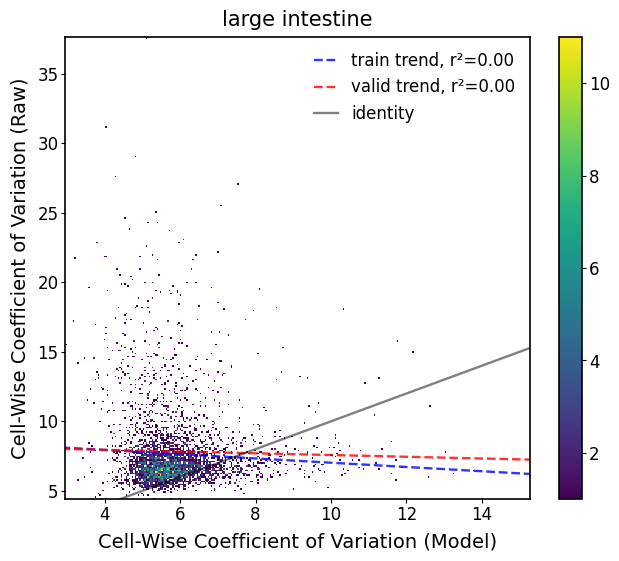

lung
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=2.93 Validation 2.84,
Pearson correlation=0.85 Validation 0.85,
Spearman correlation=0.85 Validation 0.86,
R^2=0.67 Validation 0.69,



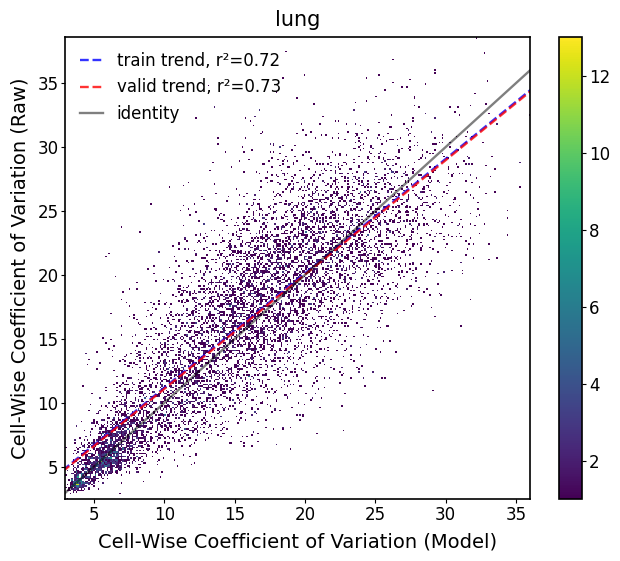

small intestine
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=3.18 Validation 3.13,
Pearson correlation=0.16 Validation 0.20,
Spearman correlation=0.18 Validation 0.20,
R^2=-13.32 Validation -9.57,



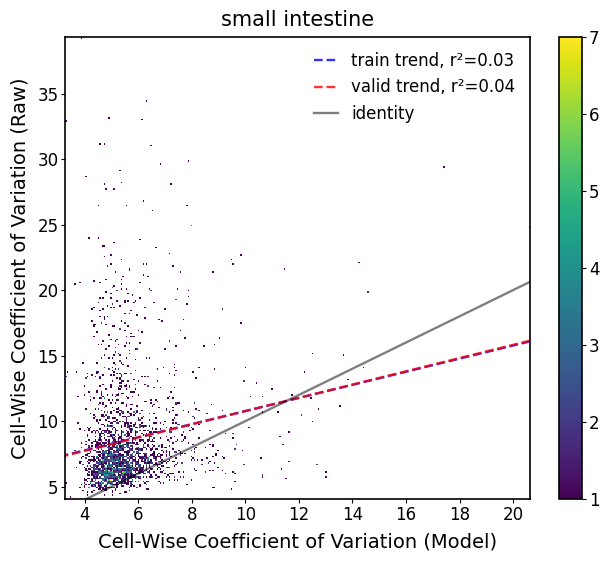

kidney
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=5.17 Validation 5.13,
Pearson correlation=0.02 Validation 0.03,
Spearman correlation=0.01 Validation 0.03,
R^2=-30.48 Validation -27.92,



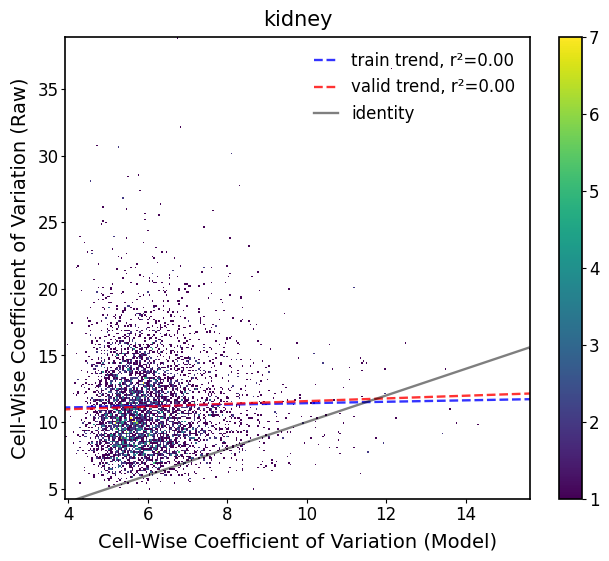

endocrine pancreas
model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=7.23 Validation 6.57,
Pearson correlation=0.21 Validation 0.16,
Spearman correlation=0.24 Validation 0.21,
R^2=-11.72 Validation -5.63,



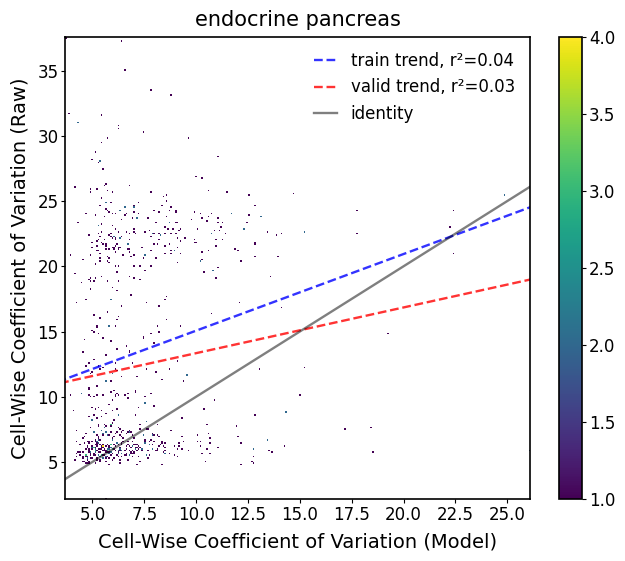

skipping aorta


In [54]:
for tissue in query_model.adata.obs['tissue'].unique():
    if len(np.where(query_model.adata.obs['tissue']==tissue)[0]) < 1000:
        print('skipping', tissue)
        continue
    print(tissue)
    ppc_plt.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d", model=query_model, indices=np.where(query_model.adata.obs['tissue']==tissue)[0])

    fig_path = f'{temp_fig_dir}ppc_cv_cell_ts_query_{tissue}.svg'
    plt.savefig(fig_path, dpi=600, bbox_inches="tight")
    plt.title(tissue)
    plt.show()

In [46]:
query_model.adata[np.where(~query_model.adata.obs['tissue'].isin(['lung', 'trachea', 'posterior part of tongue']))[0]].obs['tissue'].value_counts()

prostate gland             12316
parotid gland               8932
kidney                      8331
exocrine pancreas           7128
large intestine             6220
mammary gland               5854
anterior part of tongue     4498
sublingual gland            4158
bladder organ               4151
small intestine             3712
cornea                      2940
conjunctiva                 2084
eye                         2052
liver                       1600
endocrine pancreas          1087
cardiac atrium               787
sclera                       471
retinal neural layer         325
cardiac ventricle            302
endometrium                  230
thymus                       178
tongue                       169
skin of body                  59
uterus                        54
skin of chest                 38
aorta                         26
skin of abdomen                9
myometrium                     9
lacrimal gland                 5
Name: tissue, dtype: int64

model=SCANVI | metric=cv_cell | n_cells=104148:
Mean Absolute Error=3.58 Validation 3.62,
Pearson correlation=0.64 Validation 0.63,
Spearman correlation=0.56 Validation 0.54,
R^2=0.12 Validation 0.11,



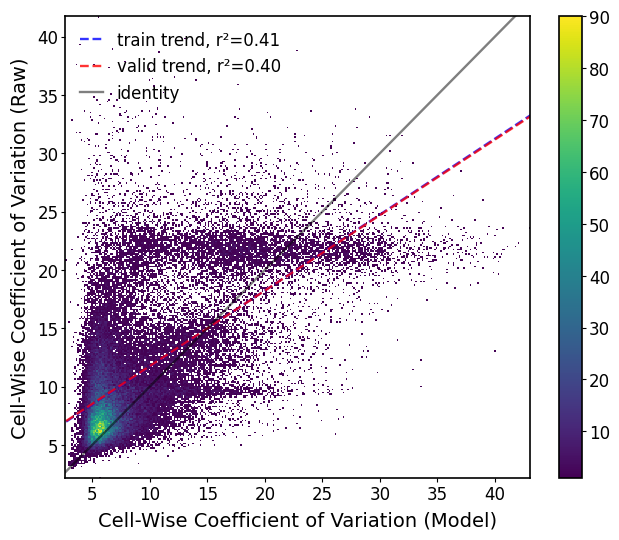

In [55]:
ppc_plt.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d", model=query_model,
                indices=np.where(~query_model.adata.obs['tissue'].isin(['lung']))[0])

fig_path = f'{temp_fig_dir}/ppc_cv_cell_ts_query_no_lung.svg'
plt.savefig(fig_path, dpi=600, bbox_inches="tight")

In [ ]:
query_model2 = query_model
query_model2.adata = query_data[query_data.obs['tissue']=='lung']

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


model=SCANVI | metric=cv_cell | n_cells=13981:
Mean Absolute Error=2.23,
Pearson correlation=0.91
Spearman correlation=0.91
r^2=0.83



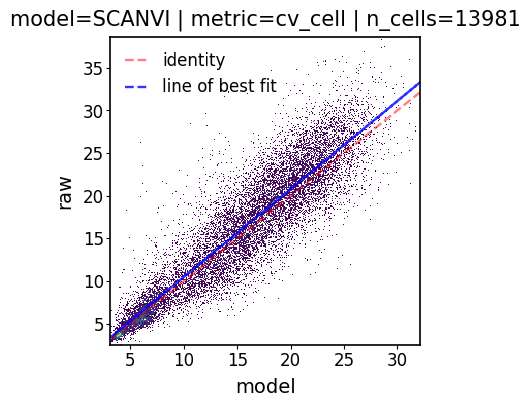

In [ ]:
ppc_lung = criticism.PosteriorPredictiveCheck(query_model2.adata[query_model2.adata.obs['tissue']=='lung'], models_dict)
# expected runtime ~8min
ppc_lung.coefficient_of_variation("features")

ppc_plt_lung = PPCPlot(ppc_lung)
ppc_plt_lung.plot_cv(model_name="SCANVI", cell_wise=True, plt_type="hist2d")

fig_path = f'{temp_fig_dir}/ppc_cv_cell_ts_query_lung.svg'
plt.savefig(fig_path, dpi=600, bbox_inches="tight")

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


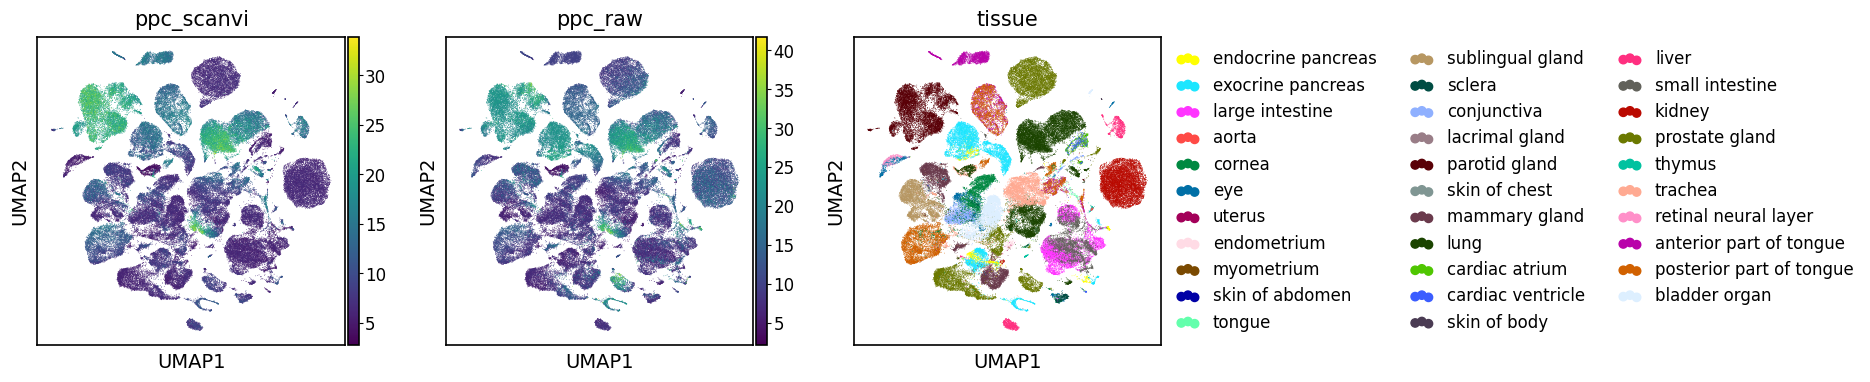

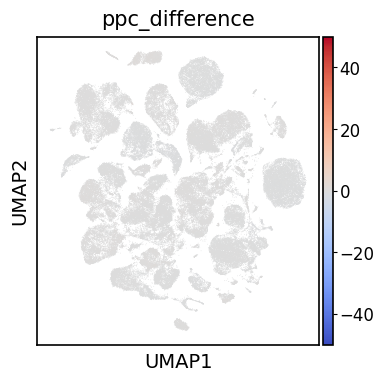

In [ ]:
query_data.obs['ppc_scanvi'] = ppc.metrics['cv_cell']['SCANVI']
query_data.obs['ppc_raw'] = ppc.metrics['cv_cell']['Raw']
query_data.obs['ppc_difference'] = (query_data.obs['ppc_scanvi'] - query_data.obs['ppc_raw']) / query_data.obs['ppc_raw']
sc.pl.umap(query_data, color=['ppc_scanvi', 'ppc_raw', 'tissue'])
sc.pl.umap(query_data, color=['ppc_difference'], color_map='coolwarm', vmax=50, vmin=-50)

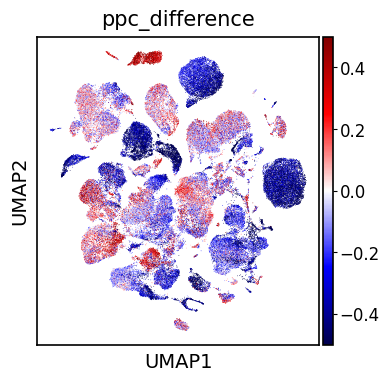

In [ ]:
sc.pl.umap(query_data, color=['ppc_difference'], color_map='seismic', vmax=0.5, vmin=-0.5, sort_order=False)

/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cane/miniconda3/envs/resolvi_new/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


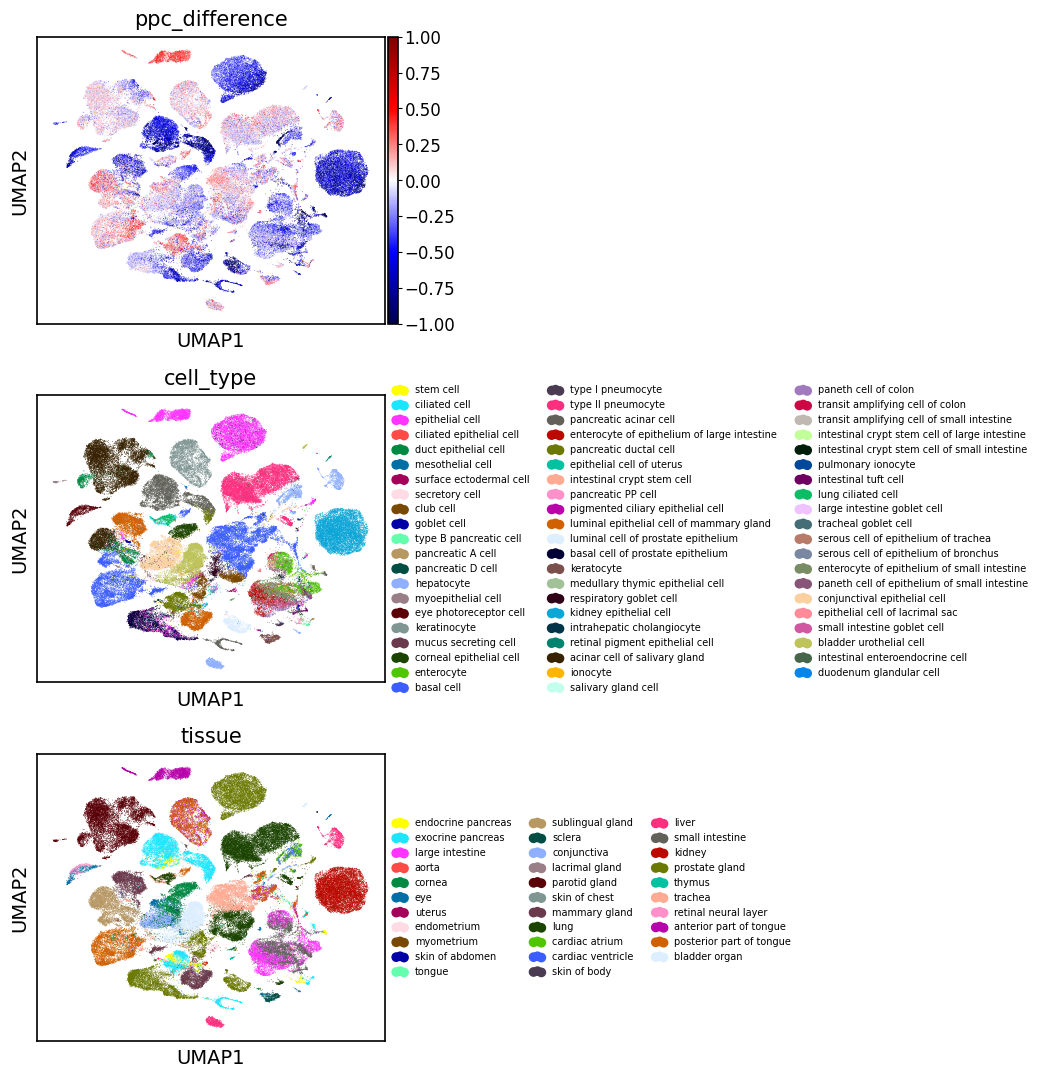

In [ ]:
query_data.obs['ppc_difference'] = np.log(query_data.obs['ppc_scanvi'] / query_data.obs['ppc_raw'])
sc.pl.umap(query_data, color=['ppc_difference', 'cell_type', 'tissue'], color_map='seismic', vmax=1.0, vmin=-1.0, ncols=1, legend_fontsize=7, sort_order=False, save='ppc_cells_ts_epithelial.svg')